In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense,LSTM
from sklearn import metrics
from datetime import timedelta, date, datetime
import time

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase3.csv to Global DataBase3.csv


In [3]:
#read dataframe from DB
df=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst = True)

df = df.sort_index()


#Handeling global outliers
GlobalOutliers =  []
for i in range(0):
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']

df = df.dropna()

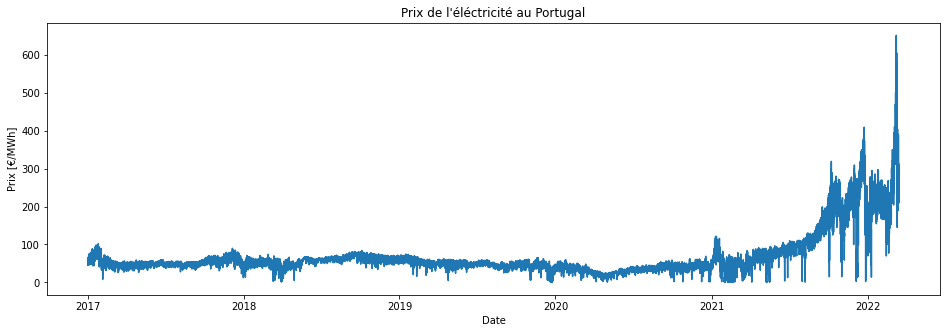

In [4]:
#Plot Prix PT after data cleaning
plt.figure(figsize=(16,5))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Prix [€/MWh]')
plt.plot(df.index, df['Price - PT [€/MWh]'])  
plt.show()

In [5]:
df_u=df[['Price - PT [€/MWh]']].dropna()
df_u

,Price - PT [€/MWh]
datetime,
2017-01-01 01:00:00,58.82
2017-01-01 02:00:00,58.23
2017-01-01 03:00:00,51.95
2017-01-01 04:00:00,47.27
2017-01-01 05:00:00,46.90
...,...
2022-03-15 19:00:00,277.80
2022-03-15 20:00:00,297.01
2022-03-15 21:00:00,311.71


In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df_u.values)
    
reframed= series_to_supervised(scaled, 14)
reframed

,var1(t-14),var1(t-13),var1(t-12),var1(t-11),var1(t-10),var1(t-9),var1(t-8),var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
14,-0.819293,-0.821106,-0.840399,-0.854777,-0.855914,-0.856836,-0.857911,-0.858372,-0.858372,-0.861352,-0.857972,-0.852811,-0.847711,-0.850415,-0.854992
15,-0.821106,-0.840399,-0.854777,-0.855914,-0.856836,-0.857911,-0.858372,-0.858372,-0.861352,-0.857972,-0.852811,-0.847711,-0.850415,-0.854992,-0.857112
16,-0.840399,-0.854777,-0.855914,-0.856836,-0.857911,-0.858372,-0.858372,-0.861352,-0.857972,-0.852811,-0.847711,-0.850415,-0.854992,-0.857112,-0.857081
17,-0.854777,-0.855914,-0.856836,-0.857911,-0.858372,-0.858372,-0.861352,-0.857972,-0.852811,-0.847711,-0.850415,-0.854992,-0.857112,-0.857081,-0.841505
18,-0.855914,-0.856836,-0.857911,-0.858372,-0.858372,-0.861352,-0.857972,-0.852811,-0.847711,-0.850415,-0.854992,-0.857112,-0.857081,-0.841505,-0.818525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45594,-0.355453,-0.354839,-0.346267,-0.254286,-0.203625,-0.203625,-0.216590,-0.216590,-0.237727,-0.239232,-0.240737,-0.220676,-0.220676,-0.220676,-0.146544
45595,-0.354839,-0.346267,-0.254286,-0.203625,-0.203625,-0.216590,-0.216590,-0.237727,-0.239232,-0.240737,-0.220676,-0.220676,-0.220676,-0.146544,-0.087527
45596,-0.346267,-0.254286,-0.203625,-0.203625,-0.216590,-0.216590,-0.237727,-0.239232,-0.240737,-0.220676,-0.220676,-0.220676,-0.146544,-0.087527,-0.042366
45597,-0.254286,-0.203625,-0.203625,-0.216590,-0.216590,-0.237727,-0.239232,-0.240737,-0.220676,-0.220676,-0.220676,-0.146544,-0.087527,-0.042366,-0.065469


In [8]:
#values = reframed_differenced.values
values = reframed.values
n_train_days=  int(len(values) * 0.5)
n_val_days= int(len(values) * 0.75)
train = values[:n_train_days, :]
val= values[n_train_days:n_val_days, :]
test = values[n_val_days:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

print(test_X)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X= val_X.reshape((val_X.shape[0], 1,val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(test_X)
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

index_test=df_u['Price - PT [€/MWh]'][n_val_days:]

[[-0.84491551 -0.84491551 -0.84021505 ... -0.87115207 -0.86924731
  -0.87849462]
 [-0.84491551 -0.84021505 -0.83745008 ... -0.86924731 -0.87849462
  -0.88703533]
 [-0.84021505 -0.83745008 -0.83235023 ... -0.87849462 -0.88703533
  -0.88764977]
 ...
 [-0.34626728 -0.25428571 -0.20362519 ... -0.22067588 -0.14654378
  -0.08752688]
 [-0.25428571 -0.20362519 -0.20362519 ... -0.14654378 -0.08752688
  -0.04236559]
 [-0.20362519 -0.20362519 -0.21658986 ... -0.08752688 -0.04236559
  -0.06546851]]
[[[-0.84491551 -0.84491551 -0.84021505 ... -0.87115207 -0.86924731
   -0.87849462]]

 [[-0.84491551 -0.84021505 -0.83745008 ... -0.86924731 -0.87849462
   -0.88703533]]

 [[-0.84021505 -0.83745008 -0.83235023 ... -0.87849462 -0.88703533
   -0.88764977]]

 ...

 [[-0.34626728 -0.25428571 -0.20362519 ... -0.22067588 -0.14654378
   -0.08752688]]

 [[-0.25428571 -0.20362519 -0.20362519 ... -0.14654378 -0.08752688
   -0.04236559]]

 [[-0.20362519 -0.20362519 -0.21658986 ... -0.08752688 -0.04236559
   -0.0654

In [9]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

filepath ='models/MODEL.hdf5'

callbacks = [EarlyStopping(monitor='val_loss',patience=50),
            ModelCheckpoint(filepath, monitor='loss', save_best_only=True, mode='min')]

In [10]:
# fit network
start_time=time.time()
history = model.fit(train_X, train_y, epochs=100, batch_size=20, callbacks=callbacks, validation_data=(val_X, val_y), shuffle=False)
exec_time= time.time()-start_time

Epoch 1/100
1140/1140 [==============================] - 12s 5ms/step - loss: 0.0047 - val_loss: 3.0262e-04
Epoch 2/100
1140/1140 [==============================] - 5s 4ms/step - loss: 3.5899e-04 - val_loss: 2.3662e-04
Epoch 3/100
1140/1140 [==============================] - 5s 4ms/step - loss: 3.0381e-04 - val_loss: 2.2743e-04
Epoch 4/100
1140/1140 [==============================] - 5s 4ms/step - loss: 2.9172e-04 - val_loss: 2.9496e-04
Epoch 5/100
1140/1140 [==============================] - 5s 4ms/step - loss: 2.7700e-04 - val_loss: 3.0803e-04
Epoch 6/100
1140/1140 [==============================] - 5s 4ms/step - loss: 2.5406e-04 - val_loss: 3.0176e-04
Epoch 7/100
1140/1140 [==============================] - 6s 5ms/step - loss: 2.3542e-04 - val_loss: 2.8982e-04
Epoch 8/100
1140/1140 [==============================] - 5s 4ms/step - loss: 2.2087e-04 - val_loss: 2.7728e-04
Epoch 9/100
1140/1140 [==============================] - 5s 5ms/step - loss: 2.0925e-04 - val_loss: 2.6573e-04
Epoc

In [11]:
model.load_weights("models/MODEL.hdf5")

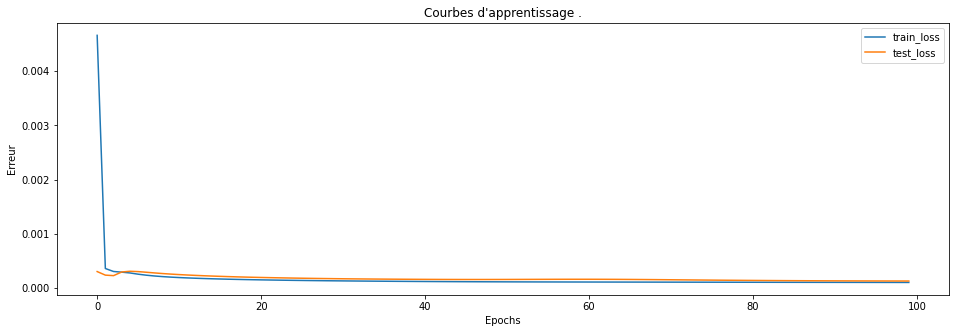

In [12]:
# plot history
plt.figure(figsize=(16,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='test_loss')
plt.gca().set(title='Courbes d\'apprentissage .', xlabel='Epochs', ylabel='Erreur')
plt.legend()

In [13]:
# make a prediction
print(test_X.shape)
yhat = model.predict(test_X)
#Transform test to be 2D
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

(11397, 1, 14)


In [14]:
test_X=pd.DataFrame(test_X)
# invert scaling for forecast
test_X[0]= yhat
inv_yhat = scaler.inverse_transform(test_X)
inv_yhat = inv_yhat[:,0]

In [15]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
test_X[0]= test_y
inv_y = scaler.inverse_transform(test_X)
inv_y = inv_y[:,0]

In [16]:
#Calculate MAE, MSE, RMSE, CV
MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
MSE=metrics.mean_squared_error(inv_y, inv_yhat)
CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
R2= metrics.r2_score(inv_y, inv_yhat)

print('Mean Absolute Error:', MAE)
print('Mean Squared Error:', MSE)  
print('Root Mean Squared Error:', np.sqrt(MSE))
print('Coefficient of Variance:',CV)
print('R2:', R2)
print('exec_time:', exec_time)

Mean Absolute Error: 10.605823367696729
Mean Squared Error: 457.1855660229364
Root Mean Squared Error: 21.38189809214646
Coefficient of Variance: 17.10952603903714
R2: 0.9400173669368606
exec_time: 500.1256637573242


[Text(0, 0.5, 'Price [€/MWh]'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, "Prix de l'éléctricité au Portugal")]

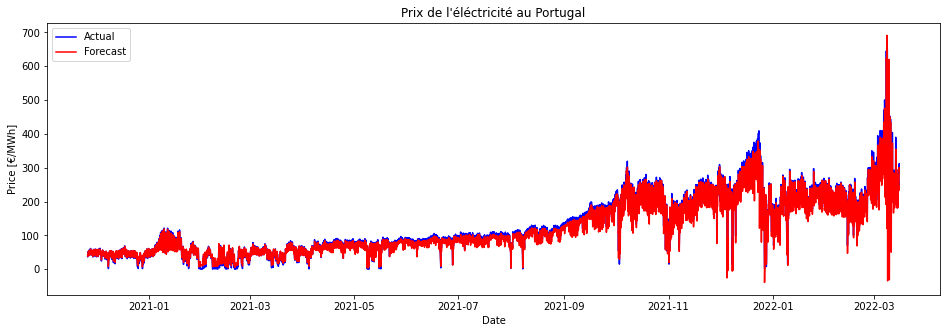

In [17]:
plt.figure(figsize=(16,5))
plt.plot(index_test[14:].index, inv_y, color='blue')
plt.plot(index_test[14:].index, inv_yhat, color='red')
plt.legend(('Actual', 'Forecast'))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Price [€/MWh]')

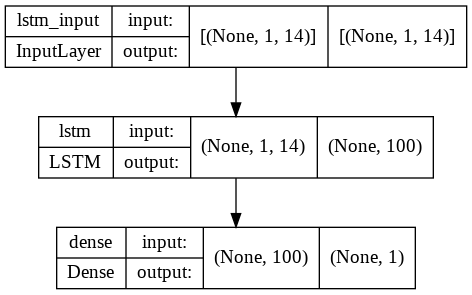

In [18]:
plot_model(model, show_shapes=True, show_layer_names=True )

In [19]:
# BEST n_in

score = []
best_n = 1
best_score = 0

for n in range(best_n, 30):
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled = scaler.fit_transform(df_u.values)
  reframed= series_to_supervised(scaled, n)
  
  #values = reframed_differenced.values
  values = reframed.values
  n_train_days=  int(len(values) * 0.5)
  n_val_days= int(len(values) * 0.75)
  train = values[:n_train_days, :]
  val= values[n_train_days:n_val_days, :]
  test = values[n_val_days:, :]
  # split into input and outputs
  train_X, train_y = train[:, :-1], train[:, -1]
  val_X, val_y = val[:, :-1], val[:, -1]
  test_X, test_y = test[:, :-1], test[:, -1]
  # reshape input to be 3D [samples, timesteps, features]
  train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
  val_X= val_X.reshape((val_X.shape[0], 1,val_X.shape[1]))
  test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
  index_test=df_u['Price - PT [€/MWh]'][n_val_days:]
    # design network
  model = Sequential()
  model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
  model.add(Dense(1))
  model.compile(loss='mse', optimizer='adam')
  # fit network
  start_time=time.time()
  history = model.fit(train_X, train_y, epochs=200, batch_size=100, validation_data=(val_X, val_y), verbose=0, shuffle=False)
  exec_time= time.time()-start_time
  # make a prediction
  
  yhat = model.predict(test_X)
  #Transform test to be 2D
  test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
  test_X=pd.DataFrame(test_X)
  # invert scaling for forecast
  test_X[0]= yhat
  inv_yhat = scaler.inverse_transform(test_X)
  inv_yhat = inv_yhat[:,0]
  # invert scaling for actual
  test_y = test_y.reshape((len(test_y), 1))
  test_X[0]= test_y
  inv_y = scaler.inverse_transform(test_X)
  inv_y = inv_y[:,0]
  #Calculate MAE, MSE, RMSE, CV
  MAE= metrics.mean_absolute_error(inv_y, inv_yhat)
  MSE=metrics.mean_squared_error(inv_y, inv_yhat)
  CV= (np.sqrt(metrics.mean_squared_error(inv_y, inv_yhat))/inv_y.mean())*100
  R2= metrics.r2_score(inv_y, inv_yhat)
  print(n)

  print('Mean Absolute Error:', MAE)
  print('Mean Squared Error:', MSE)  
  print('Root Mean Squared Error:', np.sqrt(MSE))
  print('Coefficient of Variance:',CV)
  print('R2:', R2)
  print('exec_time:', exec_time)
  print("*************************")



  if best_score < R2:
        best_n = n
print('best_n' , best_n)

KeyboardInterrupt: ignored